# Script Assignment 4

## Group 4

## Assignment

You are working as a data scientist for a financial technology company specializing in credit risk assessment. Your task is to build and evaluate an ensemble model using historical loan data to predict the likelihood of default for new loan applicants.

- Load the historical loan dataset (`loan_data.csv`) containing features such
 as credit score, income, loan amount, and default status. Preprocess the data by handling missing values, encoding categorical variables, and splitting the dataset into training and testing sets.
- Implement three different ensemble models: Random Forest, Gradient 
Boosting, and Voting Classifier. Train each ensemble model on the training dataset and evaluate its performance using appropriate evaluation metrics for classification tasks (e.g., accuracy, precision, recall, F1-score, ROC-AUC).
- Compare the performance of the three ensemble models and select the 
best-performing model based on evaluation metrics. Provide insights into why the selected ensemble model might be well-suited for credit risk assessment in fintech.

## Links

- [Kaggle Loan Default Dataset](https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data)
- [Data Cleaning and Preprocessing Tactics](https://www.kaggle.com/code/nkitgupta/advance-data-preprocessing)

## Imports

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer

## Load the dataset 

In [157]:
# Load the dataset
file_path = '../data/loan_data.csv'
df_loan_data = pd.read_csv(file_path)
df_loan_data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


## Review the dataframe and visualize missing data

In this section, we will review the dataframe's structure and visualize the missing data.  We will also create a function to determine which columns have missing data and the percentage of missing data in each column.

### Review the dataframe

In [158]:
df_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

### Calculate missing data percentages

In [159]:
def calculate_missing_percentages(df):
    """Calculate the percentage of missing data in each column of a dataframe."""
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    miss_pct = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        miss_pct[col] = per
        print(f"{col}: {null_count} ({per:.3f}%)")
    return miss_pct

In [160]:
_ = calculate_missing_percentages(df_loan_data)

loan_limit: 3344 (2.249%)
approv_in_adv: 908 (0.611%)
loan_purpose: 134 (0.090%)
rate_of_interest: 36439 (24.510%)
Interest_rate_spread: 36639 (24.645%)
Upfront_charges: 39642 (26.664%)
term: 41 (0.028%)
Neg_ammortization: 121 (0.081%)
property_value: 15098 (10.155%)
income: 9150 (6.155%)
age: 200 (0.135%)
submission_of_application: 200 (0.135%)
LTV: 15098 (10.155%)
dtir1: 24121 (16.225%)


### Visualize missing data

The `missingno` library provides a matrix visualization of the missing data, and the `matplotlib` library provides a bar chart of the missing data percentages.

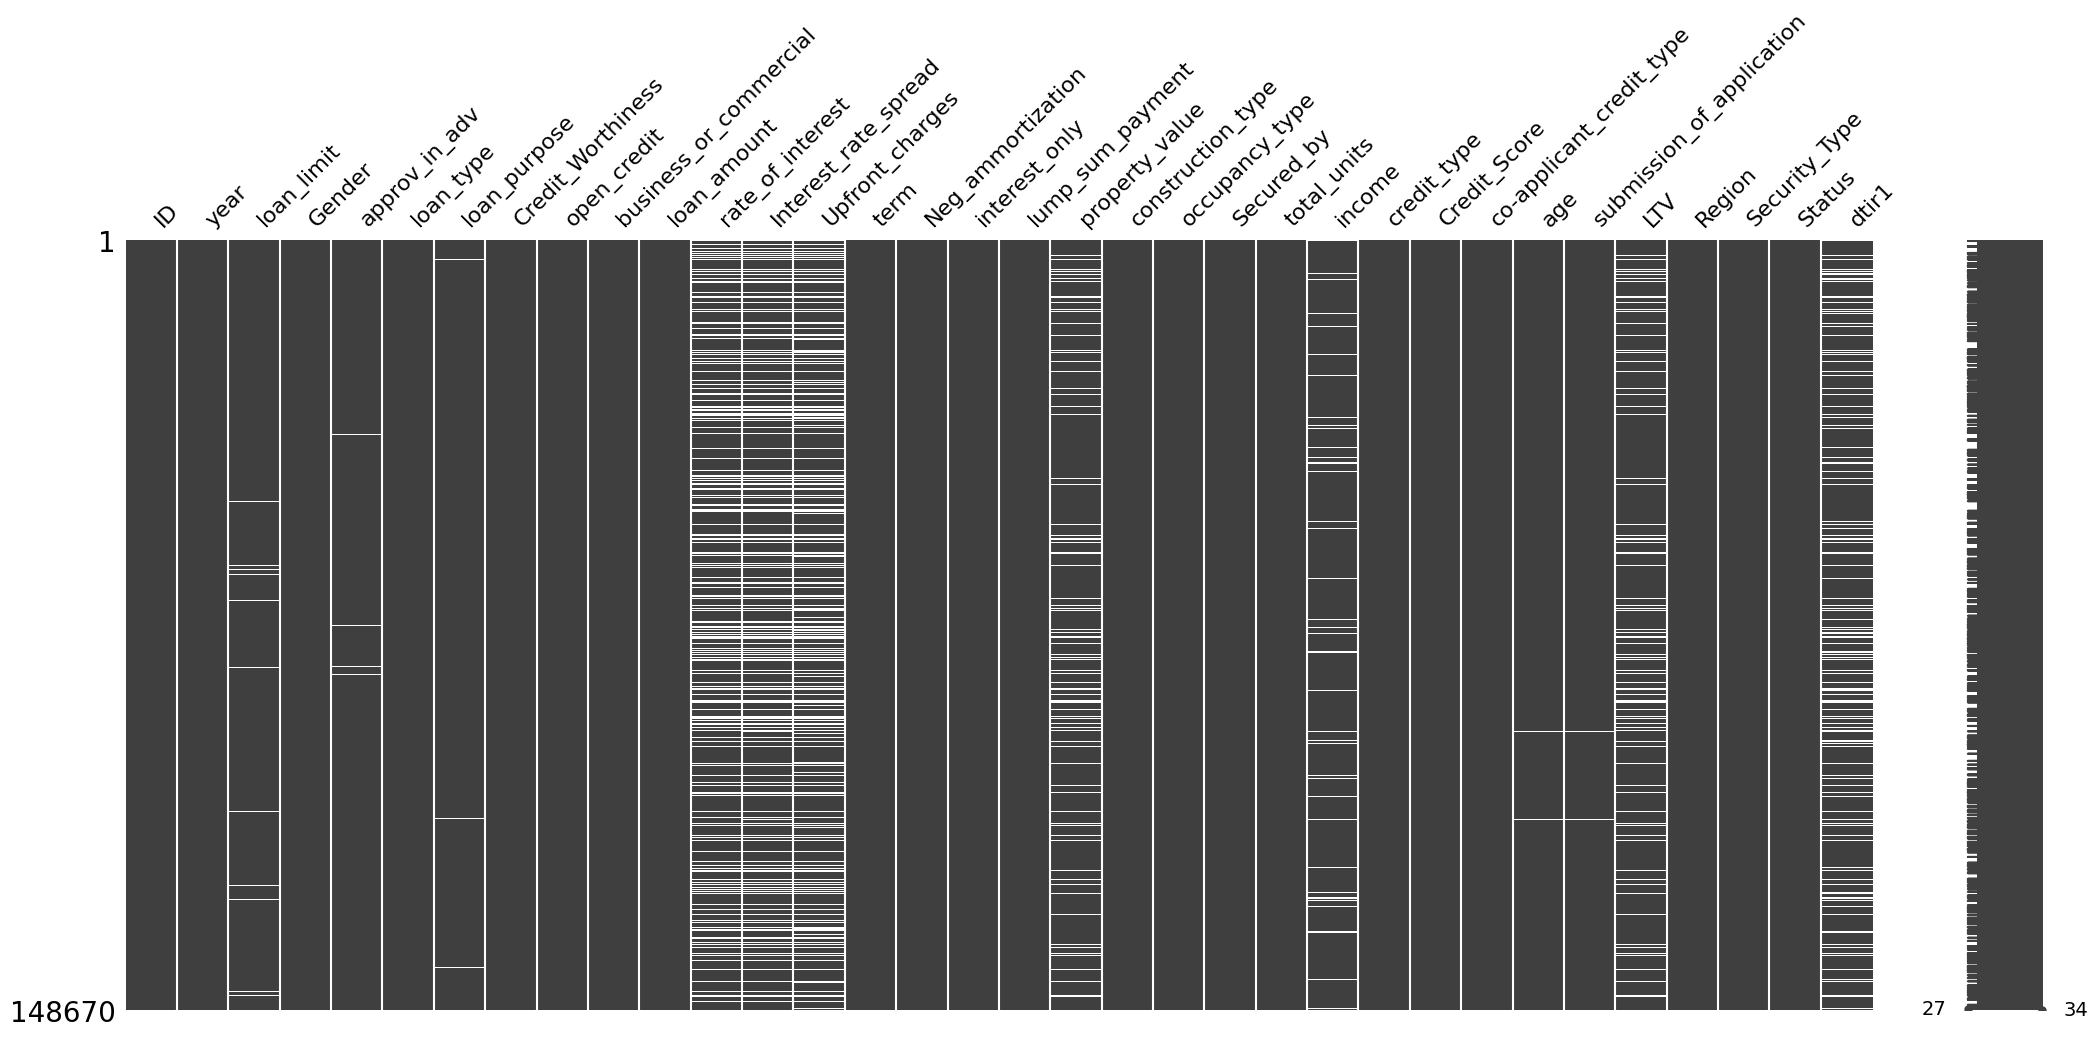

<Figure size 1500x900 with 0 Axes>

In [161]:
msno.matrix(df_loan_data)
plt.figure(figsize = (15,9))
plt.show()

From both the chart and statistics above, there are a few columns with substantial missing data. We will need to address this missing data before we can proceed with building the ensemble models.

## Data Preprocessing

In this section, we will review features, handle the missing data, encode the categorical variables, and split the dataset into training and testing sets.

### Review features

We'll start by reviewing the features in the dataset and removing any that we know have little to no impact on the model.  

According to an article on forbes.com, the following features are important for credit risk assessment:

- Credit Score and History
- Income
- Debt-to-income Ratio
- Collateral
- Origination Fee

In order to simplify the dataset, we'll remove the following columns: 


In [162]:
df_loan_data.drop(['loan_limit','Gender', 'approv_in_adv','loan_type', 'loan_purpose', 'Credit_Worthiness','open_credit',
        'business_or_commercial', 'rate_of_interest', 'Interest_rate_spread', 'Neg_ammortization', 'interest_only',
        'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type',
        'co-applicant_credit_type', 'submission_of_application', 'Region', 'Security_Type', 'ID', 'year'], axis = 1, inplace = True)

df_loan_data.head()

,loan_amount,Upfront_charges,term,property_value,income,Credit_Score,age,LTV,Status,dtir1
0,116500,NaN,360.0,118000.0,1740.0,758,25-34,98.728814,1,45.0
1,206500,NaN,360.0,NaN,4980.0,552,55-64,NaN,1,NaN
2,406500,595.0,360.0,508000.0,9480.0,834,35-44,80.019685,0,46.0
3,456500,NaN,360.0,658000.0,11880.0,587,45-54,69.376900,0,42.0
4,696500,0.0,360.0,758000.0,10440.0,602,25-34,91.886544,0,39.0


### Handle missing data


In [163]:
# Review the missing data percentages
_ = calculate_missing_percentages(df_loan_data)

Upfront_charges: 39642 (26.664%)
term: 41 (0.028%)
property_value: 15098 (10.155%)
income: 9150 (6.155%)
age: 200 (0.135%)
LTV: 15098 (10.155%)
dtir1: 24121 (16.225%)


#### Handle missing numerical data

We will use the SimpleImputer class to fill in the missing data.  We will use the mean value for numerical columns and the most frequent value for categorical columns.

In [164]:
# Only numerical features
num_cols = [col for col in df_loan_data.columns if df_loan_data[col].dtype != 'object']
print(num_cols)

['loan_amount', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status', 'dtir1']


In [165]:
imputer = SimpleImputer(strategy='mean')
# Run SimpleImputer on a subset of columns on df_loan_data
for col in num_cols:
    df_loan_data[col] = imputer.fit_transform(df_loan_data[[col]])

df_loan_data.head()

,loan_amount,Upfront_charges,term,property_value,income,Credit_Score,age,LTV,Status,dtir1
0,116500.0,3224.996127,360.0,118000.000000,1740.0,758.0,25-34,98.728814,1.0,45.000000
1,206500.0,3224.996127,360.0,497893.465696,4980.0,552.0,55-64,72.746457,1.0,37.732932
2,406500.0,595.000000,360.0,508000.000000,9480.0,834.0,35-44,80.019685,0.0,46.000000
3,456500.0,3224.996127,360.0,658000.000000,11880.0,587.0,45-54,69.376900,0.0,42.000000
4,696500.0,0.000000,360.0,758000.000000,10440.0,602.0,25-34,91.886544,0.0,39.000000


In [166]:
df_loan_data.isnull().sum()

loan_amount          0
Upfront_charges      0
term                 0
property_value       0
income               0
Credit_Score         0
age                200
LTV                  0
Status               0
dtir1                0
dtype: int64

#### Handle missing categorical variables

Now we'll set our sights on cleaning up the categorical variables.  We'll start by identifying the categorical variables and then filling in the missing data with the most frequent value.

In [167]:
df_loan_data.dropna(inplace = True)
df_loan_data.isnull().sum()


loan_amount        0
Upfront_charges    0
term               0
property_value     0
income             0
Credit_Score       0
age                0
LTV                0
Status             0
dtir1              0
dtype: int64

### Encode categorical variables

We will use the LabelEncoder class to encode the age variable.

In [168]:
label_encoder = LabelEncoder()
df_loan_data['age'] = label_encoder.fit_transform(df_loan_data['age'])
df_loan_data['age']

0         0
1         3
2         1
3         2
4         0
         ..
148665    3
148666    0
148667    2
148668    3
148669    2
Name: age, Length: 148470, dtype: int32

### Split the dataset into training and testing sets

In [169]:
# Split the dataset into training and testing sets
X = df_loan_data.drop('Status', axis=1)
y = df_loan_data['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)